## The puzzle

At the IBM-Prague Thanksgiving gathering, my colleague Borek's daughter was playing with a nice puzzle: A 5x5 board on which you stack 12 shapes made of connected balls into a pyramid.  The 55 balls that make up the shape pile nicely into a pyramid 5 levels high.  There's also a different 5x11 board where the pieces need to fit together in a plane.

Some pictures are here http://www.smartgames.eu/en/smartgames/iq-puzzler and a video below.

In [4]:
from IPython.display import IFrame
# Youtube
IFrame('https://www.youtube.com/embed/xL5rYrF8Dck?rel=0&amp;&amp;showinfo=0',width="560",  height="420")


## The problem and outline of a solution
This got Borek and I thinking if we can solve this with a computer.  The problem reduces to finding an [exact cover](https://en.wikipedia.org/wiki/Exact_cover) of the board (the 55 slots in the 5x5 pyramid or the 11x5 rectangle).  The cover candidates are the 12 pieces, in all possible positions (orientations and translations) that intersect the board.  

If we enumerate all the slots in the board, a single positioned piece can be represented as boolean 1x55 vecor, with ones for the slots where the piece is present, and zeros elsewhere.  We also need to keep track of the identity of the piece, because we cannot use the same piece in multiple positions.  So we extend the 1x55 vector with 12 more columns (to make a 1x67 vector).  If we are using the $i$th piece, we will set the $55+i$th element to 1, and the remaining added 11 elements to 0.  

Now we can list all M cover candidates as rows in a Mx67 matrix.  Solving the problem reduces to finding a subset of rows of the matrix, such that the sum of each column in the subset is exactly one.

The exact cover problem is a [somewhat famous](https://en.wikipedia.org/wiki/Karp%27s_21_NP-complete_problems) [NP-complete](https://en.wikipedia.org/wiki/P_versus_NP_problem) problem.  Donald Knuth described an elegant implementation of the exact cover search on sparse matrices (such as our M) which he called [dancing links](https://arxiv.org/abs/cs/0011047). [Various](https://github.com/DavideCanton/DancingLinksX) [implementations](https://github.com/mharrys/sudoku) of dancing links exist on github.  We use one of the python including implementations to solve the problem, given M.

As I was writing this up, I found a very nice description of [solving the planar board puzzle](http://www.ams.org/samplings/feature-column/fcarc-kanoodle) with dancing links. You should probably read it to completely understand the solution. (Side note: One of us is wrong about the number of positioned pieces: I think it's 2828 (see below) and the linked article claims 2222.)

## A coordinate system for the board and positioned pieces
It is natural to represent the planar 5x11 board as integer coordinates in 2D.  
For the pyramid board, it's more convenient to chose a non-orthonormal basis $B$, such that the board slots and the balls of positioned pieces still fall on integer coordinates in that basis. One possibility is the basis
$$
B = \left\{
\begin{bmatrix}
         1\\
         0\\
         0\\
\end{bmatrix}
,
\begin{bmatrix}
         0\\
         1\\
         0\\
\end{bmatrix}
,
\begin{bmatrix}
         \frac{1}{2}\\
         \frac{1}{2}\\
         \frac{\sqrt{2}}{2}\\
\end{bmatrix}
\right\}
$$

The pyramid way of arranging the balls is called "cubic closed packed". It is one of the two ways of [packing equal sized spheres as closesly as possible](https://en.wikipedia.org/wiki/Close-packing_of_equal_spheres).  The other (equally dense) way to pack the spheres is called hexagonal close-packed and there is a convenient basis for it also.

## Finding all positioned pieces
How do we find all the positioned pieces from the 12 pieces so we can build the Mx67 cover matrix? (Remember, a positioned piece is a rotated, translated piece that is fully contained in the board).  We first find all the legal rotations of a piece in the standard, orthonormal basis.  We then change it's coordinate system to the convenient basis $B$ we described above.  In that coordinate system, for each rotation we can:
1. Sanity-check that our rotation was legal (it was if the piece coordinates are integers).
1. Translate the rotated piece to every possible position within the bounding box of the board.  Only those translations that leave the piece fully inside the board are the valid positioned pieces. 

So the only remaining question is:
### Which orientations are valid?

#### The planar 5x11 planar board case
For the planar board (in the X-Y plane), it's obvious that the legal rotations are around the Z axis by $90^{\circ}$ 0,1,2 or 3 times, plus "the flip" which is a rotation around the Y axis by $180^{\circ}$ 0 or 1 times.  And in this case, the rotations commute which is not true in general for 3D rotations. ('commute' means that the rotations and flips can be reordered without changing the outcome).  So we only need to consider 2x8 different rotations for each piece.  If the piece happens to be symmetric, some rotations give us the same shape, and we can remove duplicates (e.g. a square piece has only a single orientation after the duplicates have been removed).

Following the above algorithm, it turns out that starting from the 12 given puzzle pieces, there are M=2828 positioned pieces on the planar board, and we are dealing with 2828x67 cover matrix.

#### The pyramid board case
This one gets more complicated and this is the part that I understand the least about solving the puzzle, but I will write down what I know.

Our piece can be oriented to 'point' from the origin along the axes in the $X-Y$ plane, and also along the 8 diagnonals in the directions of 
$$
\begin{bmatrix}
         \pm 1\\
         \pm 1\\
         \pm 1\\
\end{bmatrix}
$$
and still remain on the lattice.  

For each direction, the piece can also be rotated around it's pointing direction by $180^{\circ}$ and still remain on the lattice.
So we have 24 possible orientations.   

It **looks** like that's all, but I have no proof so far. May be I'm not seeing some valid but hard-to-see rotation?  Can it be proved that truly there are no more than 24 possible rotations?  Any advice on how to do this smarter is welcome from some knowledgable person, e.g. an abstract algebraist or a crystallographer or a solid-state chemist.

## Rotation of shapes on a lattice.



If a rotation $M$ is an isomorphism of the lattice, it is a valid rotation for a shape (FIXME: It feels like it's also necessary for $M$ to be a lattice isomorphism, but I haven't proved it yet).

Our lattice looks like a [Monoclinic crystal system with a Oblique rhombic prism
unit cell](https://en.wikipedia.org/wiki/Monoclinic_crystal_system), and there are some references to groups which may explain more.

It looks like all orientations can be generated by rotating the piece by $90^{\circ}$ 0,1,2 or 3 times about the diagnoals in the $X-Y$ plane, or by rotating by $180^{\circ}$ 0 or 1 times about the z-axis.  So,

1. Pick an axis of rotation from 
$$
\begin{bmatrix}
         0\\
         0\\
         1\\
\end{bmatrix}
,
\begin{bmatrix}
         \frac{\sqrt{2}}{2}\\
         \frac{\sqrt{2}}{2}\\
         0\\
\end{bmatrix}
,
\begin{bmatrix}
         \frac{\sqrt{2}}{2}\\
         -\frac{\sqrt{2}}{2}\\
         0\\
\end{bmatrix}
$$
2. rotate about it by a multiple of $90^{\circ}$ if it's a diagonal or $180^{\circ}$ if it's the z axis.
3. Repeat from step 1 with one of the remaining axes.

The above gives 192 rotations, so some of the 24 valid orientations will be created more than once.



This representation immediately tells you if a piece position is actually valid. A positioned piece is valid if the slot centers are on the integer grid, and it is entirely contained within the board. For example if the original piece (a hockey stick shape) is represented as 
\begin{matrix}
         (0,0)\\
         (0,1)\\
         (0,2)\\
         (0,3)\\
         (1,0)\\
\end{matrix}, a 90 degree rotation, followed by a (1,0) shift yields a valid positioned piece.  A 60

In [ ]:
!pip install matplotlib numpy ipympl ipywidgets nodejs-bin
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib"

In [1]:
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math
from itertools import product, permutations
np.set_printoptions(formatter={'float_kind':lambda x: "%.3g" % x})

import coverSolver
from coverSolver import *

The following will generate three pyramid solutions.


In [12]:
%%time
rotations,pieces=pyramidProblem()
s= solve(rotations,pieces,3)

number of oriented, positioned shapes (cover candidates): 1646
number of solutions: 3
CPU times: user 3.52 s, sys: 7.64 ms, total: 3.52 s
Wall time: 3.53 s


The following should generate an interactive 3d-model that can be rotated with a mouse, to see where all the pieces should go.

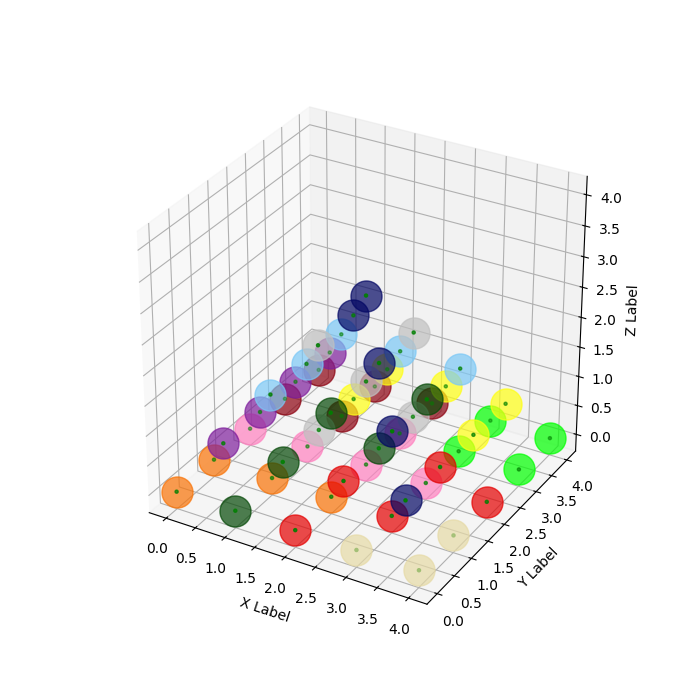

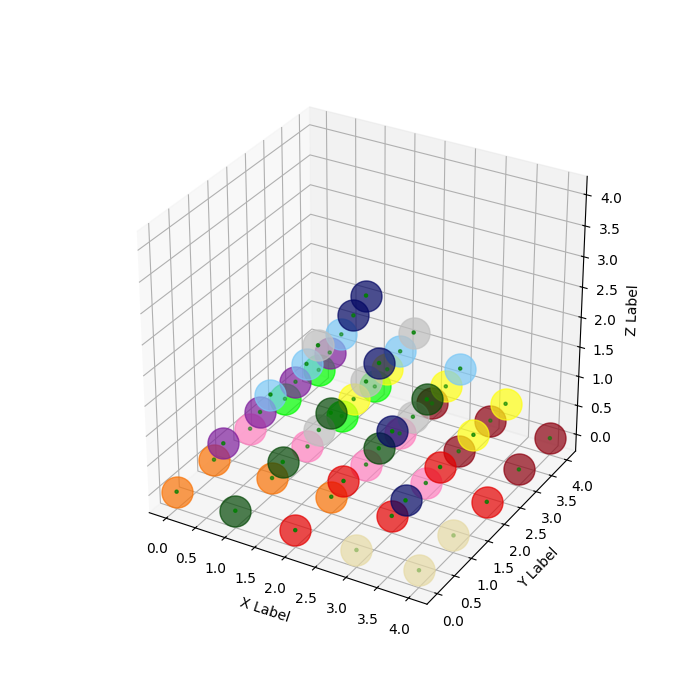

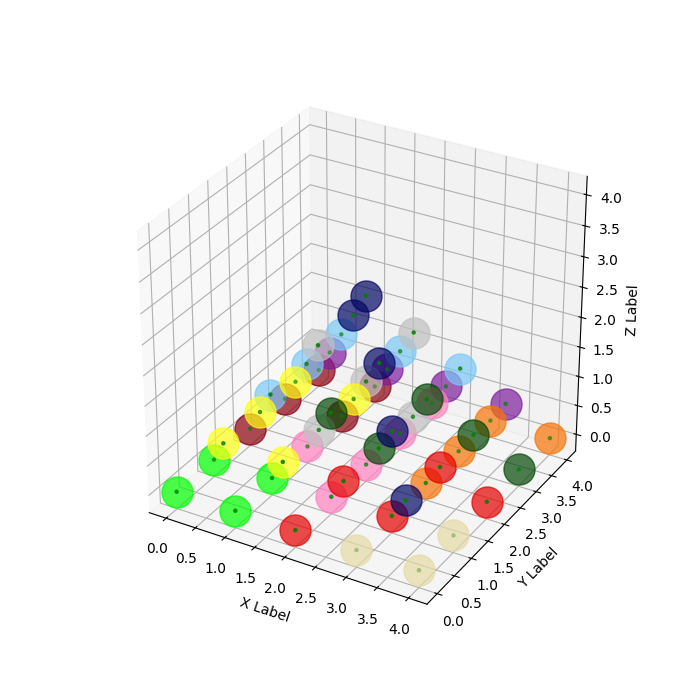

In [13]:
%matplotlib widget
s[0].visualize()
s[1].visualize()
s[2].visualize()

In [8]:
%%time
p=rectangleProblem()
s= solve(*p,100)

number of oriented, positioned shapes (cover candidates): 1789
number of solutions: 100
CPU times: user 209 ms, sys: 6.58 ms, total: 215 ms
Wall time: 213 ms


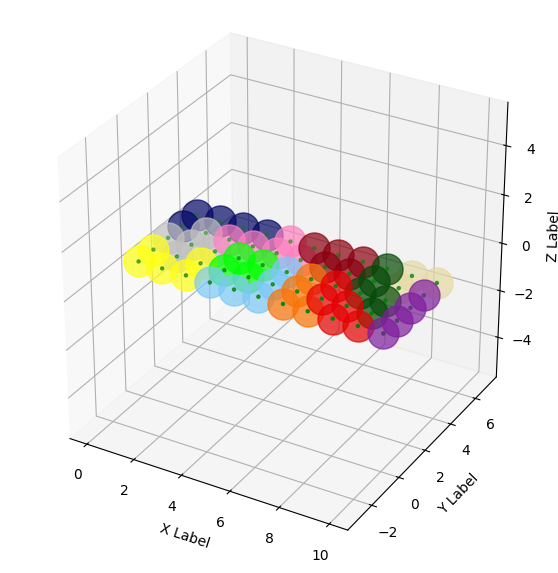

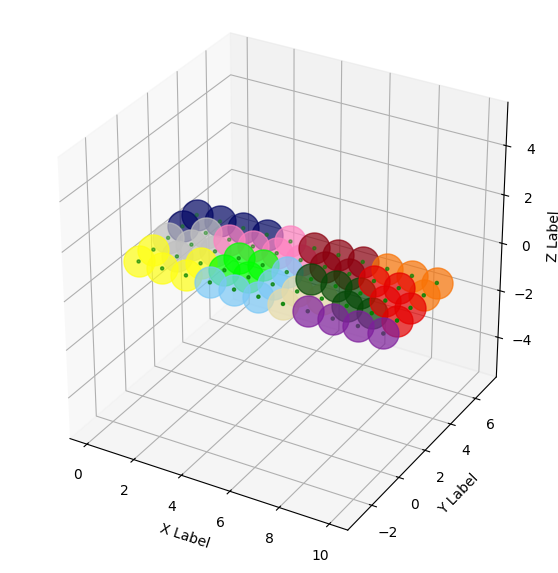

In [3]:
s[0].visualize()
s[1].visualize()

In [29]:
#diagonals in the X-Y plane, are the rotation axes, with 4-fold symmetry each
#each row is a rotation axis
rots=rotations(np.array(
    [[1,1,0],
     [1,-1,0],
     [0,1,0]
    ]), 
    np.array([4,4,2]).T)

orientSet=ShapeSet()
for p in pieces:
    orientSet.extend(p.orientations(rots))


TypeError: 'numpy.ndarray' object is not callable

### Translations
For every orientation, we need to make a list of possible translations that fit inside the board. For a shape to fit inside the board, it's bounding box needs to fit inside the board's bounding box.

In [ ]:
# stateSet=ShapeSet()
# for p in orientSet[:1]:
#     stateSet.extend(p.containedTranslations(u.board))
d=p.containedTranslations(u.board)


In [ ]:
orientSet

In [ ]:
s=ShapeSet([ pieces[0]])
# s.visualize(individually=True)